In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
sales = pd.read_csv("sales.csv")
sales['date'] = pd.to_datetime(sales["date"])

In [4]:
daily_sum = sales.groupby('date')['total_amount'].sum().reset_index()
print(daily_sum)

          date  total_amount
0   2023-09-01    1992732.84
1   2023-09-02     223872.19
2   2023-09-03     170202.43
3   2023-09-04     148226.80
4   2023-09-05    1219150.59
..         ...           ...
116 2023-12-26     854042.45
117 2023-12-27     561265.70
118 2023-12-28     723187.46
119 2023-12-29     872265.60
120 2023-12-30     144205.35

[121 rows x 2 columns]


In [5]:
daily_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          121 non-null    datetime64[ns]
 1   total_amount  121 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


In [6]:
sales['date'] = sales['date'].dt.to_period("D")
monthly_sales = sales.groupby('date').sum().reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

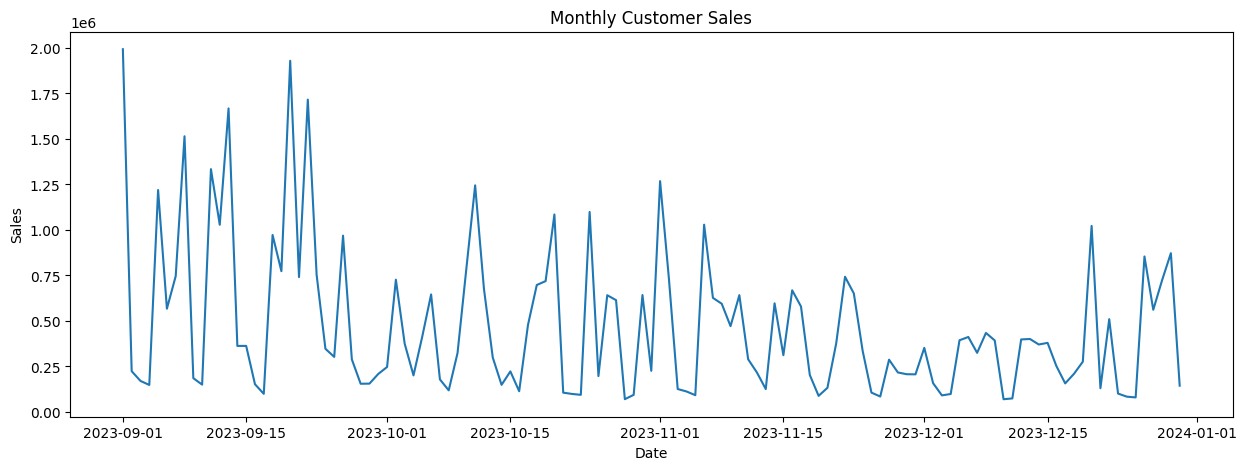

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['total_amount'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

In [8]:
monthly_sales['sales_diff'] = monthly_sales['total_amount'].diff()
monthly_sales = monthly_sales.dropna()

In [9]:
supervised_data = monthly_sales.drop(['date', 'total_amount'], axis=1)

In [10]:
# Prepare Supervised Data
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)

In [11]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [13]:
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

In [14]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
act_sales = monthly_sales['total_amount'][-13:].to_list()

Create Random Forrest Regressor Model

In [15]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pre = rf_model.predict(X_test)

rf_pre = rf_pre.reshape(-1, 1)
rf_pre_test_set = np.concatenate([rf_pre, X_test], axis=1)
rf_pre_test_set = scaler.inverse_transform(rf_pre_test_set)

In [16]:
result_list = []
for index in range(0, len(rf_pre_test_set)):
    result_list.append(rf_pre_test_set[index][0] + act_sales[index])
rf_pre_series = pd.Series(result_list, name="RandomForest Prediction")
predict_df = predict_df.merge(rf_pre_series, left_index=True, right_index=True)

In [17]:
rf_mse = np.sqrt(mean_squared_error(predict_df['RandomForest Prediction'], monthly_sales['total_amount'][-12:]))
rf_mae = mean_absolute_error(predict_df['RandomForest Prediction'], monthly_sales['total_amount'][-12:])
rf_r2 = r2_score(predict_df['RandomForest Prediction'], monthly_sales['total_amount'][-12:])
print("RandomForest MSE: ", rf_mse)
print("RandomForest MAE: ", rf_mae)
print("RandomForest R2: ", rf_r2)

RandomForest MSE:  371067.4146220768
RandomForest MAE:  277846.64855833334
RandomForest R2:  -1.0439236002484642


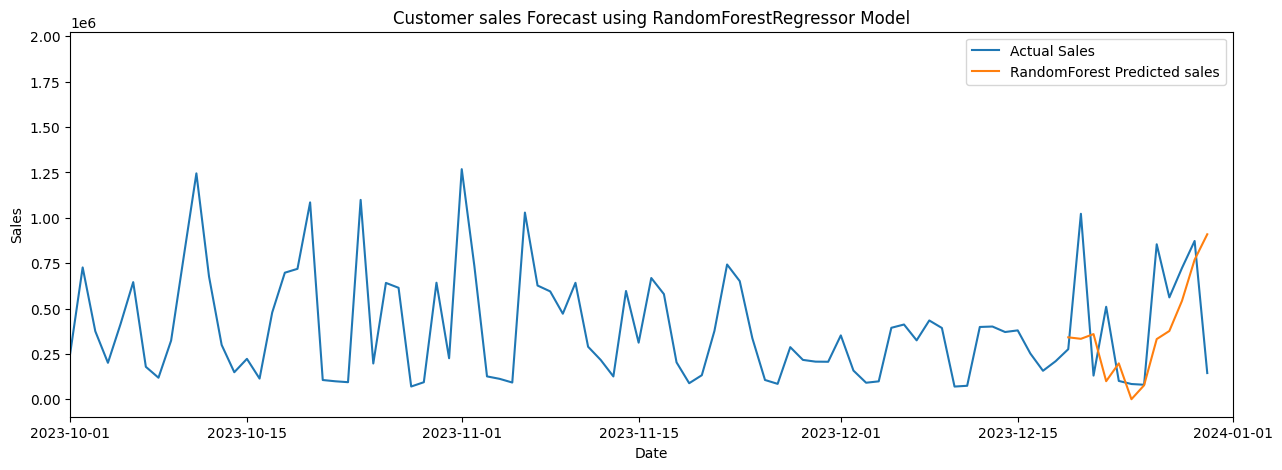

In [18]:
start_date = pd.to_datetime("2023-10-01")
end_date = pd.to_datetime("2024-01-01")

plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['total_amount'])
plt.plot(predict_df['date'], predict_df['RandomForest Prediction'])
plt.title("Customer sales Forecast using RandomForestRegressor Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'RandomForest Predicted sales'])

plt.xlim(start_date, end_date)

plt.show()